In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

In [2]:
# Rename the path as necessary to where the data is stored
flights = pd.read_csv('../data/raw_flights_10000_random.csv')

In [3]:
# Keep column list handy as reference
flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [4]:
# Check total number of null values
flights['arr_delay'].isnull().sum()

189

In [5]:
# Check total number of null values from cancelled and diverted flights
print(flights[flights['cancelled'] == 1].shape[0])
print(flights[flights['diverted'] == 1].shape[0])
flights[flights['cancelled'] == 1].shape[0] + flights[flights['diverted'] == 1].shape[0]

168
19


187

In [6]:
# Find the two other null values and check why they are null
null_filter = (flights.arr_delay.isnull()) & (flights.cancelled == 0) & (flights.diverted == 0)
flights[null_filter].iloc[:, -28:-9]

,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance
3417,1230,1228.0,-2.0,14.0,1242.0,1234.0,13.0,1247,1247.0,NaN,0,NaN,0,N,77,79.0,52.0,1,264
4537,1656,1657.0,1.0,26.0,1723.0,1716.0,3.0,1719,1719.0,NaN,0,NaN,0,N,83,82.0,53.0,1,302


### Note: only two null values, but both should be zero since dep_delay + flight_time_delay is zero -> input error!

### Will manually change the values

In [7]:
# Manually change two null values to zero
flights.loc[3417, 'arr_delay'] = 0
flights.loc[4537, 'arr_delay'] = 0
flights.loc[4537, 'arr_delay'], flights.loc[3417, 'arr_delay']

(0.0, 0.0)

In [8]:
# Make a flight delay series for further inspection; drop NAs as they are cancelled or d
flights_delay = flights.arr_delay
flights_delay.dropna(inplace=True) 
flights_delay.describe()

count    9813.000000
mean        5.634974
std        52.540674
min      -158.000000
25%       -15.000000
50%        -6.000000
75%         8.000000
max      1394.000000
Name: arr_delay, dtype: float64

In [9]:
shapiro = st.shapiro(flights_delay)
shapiro
# Shapiro says no

/Users/robertjfpal/opt/anaconda3/envs/the_way/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.44402360916137695, pvalue=0.0)

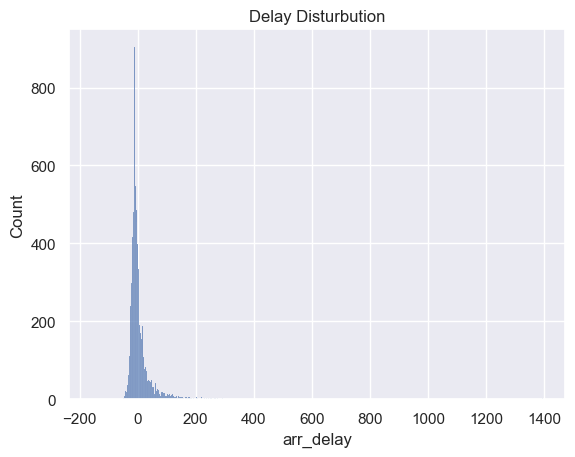

In [10]:
# Do visual inspection of disturbution
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set_theme(style="darkgrid")
df = flights_delay

sns.histplot(data=df).set_title('Delay Disturbution')
plt.show()

# There are some outlier points -> needs a log transformation

In [31]:
# shift all the data by the minimum value plus 1 for log transformation 
# based on: https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html
flights_delay_shift = flights_delay + 159

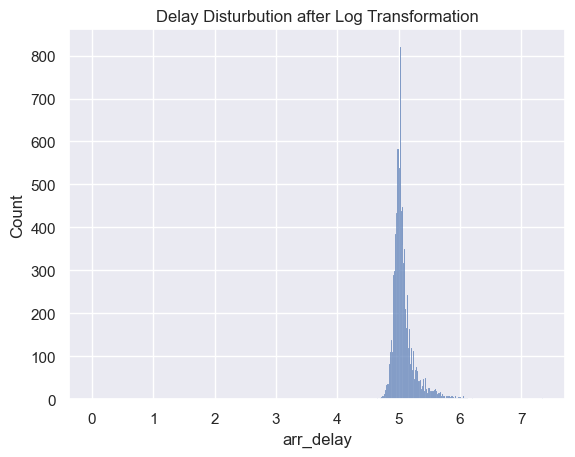

In [32]:
sns.set(style="darkgrid")

df_log = np.log(flights_delay_shift)

sns.histplot(data=df_log).set_title('Delay Disturbution after Log Transformation')
plt.show()

Note: After log transformation, distribution is still slightly skewed. 

In [13]:
# transform fl_date year and month to aggregate and find monthly stats
import datetime as dt

pd.to_datetime(flights.fl_date)
flights['month'] = pd.to_datetime(flights.fl_date).dt.month
flights['year'] = pd.to_datetime(flights.fl_date).dt.year

In [14]:
# Overall stats for delays: same as previously printed
pd.DataFrame(flights.arr_delay.agg(['mean', 'median', 'std']))

,arr_delay
mean,5.634974
median,-6.000000
std,52.540674


In [15]:
summary = pd.DataFrame(flights[['arr_delay','month']].groupby('month').agg(['mean', 'median', 'std']))
summary

arr_delay                  
            mean median        std
month                             
1       4.877915   -5.0  54.192855
2       9.150281   -4.0  58.841499
3       3.530090   -6.0  44.813296
4       1.802253   -7.0  38.144179
5       8.966467   -5.0  65.308189
6      11.159353   -4.0  61.687896
7       9.722038   -5.0  51.715056
8       8.735327   -6.0  76.789413
9       2.071879   -8.0  51.745284
10      2.017978   -7.0  33.478931
11      1.503038   -7.0  33.488709
12      3.252888   -6.0  36.139319

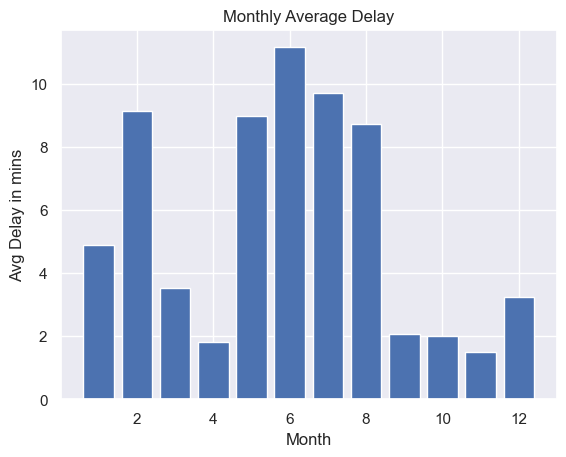

In [16]:
# Make a bar chart 
y = summary[('arr_delay', 'mean')]
x = summary.index
plt.bar(x, y)
plt.title('Monthly Average Delay')
plt.xlabel('Month')
plt.ylabel('Avg Delay in mins')
plt.show()

### Delay times are higher in peak summer season, due to summer travel, and in the winter, due to the weather, as one might expect.